In [1]:
library(GenomicRanges)
library(TxDb.Hsapiens.UCSC.hg19.knownGene)
library(org.Hs.eg.db)
library(annotate)
library(stringr)
library(XML)
library(qqman)

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb

Loading required package: GenomicFeatures

Loading required package: AnnotationDbi

Loading required package: Biobase

Welc

In [3]:
data <- read.csv(file='vst_results.csv')
data$chr <- sub("^", "chr", data$chr)

data$X <- NULL

In [4]:
coordinates <- data[, c(1,2,3)]
names(coordinates) <- c("Chromosome", "Start", "End")

In [5]:
intervals = GenomicRanges::makeGRangesFromDataFrame(coordinates)
txdb = TxDb.Hsapiens.UCSC.hg19.knownGene

In [6]:
intervals

GRanges object with 8650 ranges and 0 metadata columns:
         seqnames              ranges strand
            <Rle>           <IRanges>  <Rle>
     [1]     chr1       228416-267160      *
     [2]     chr1       471226-471326      *
     [3]     chr1       712534-763301      *
     [4]     chr1       763301-763482      *
     [5]     chr1       769541-787076      *
     ...      ...                 ...    ...
  [8646]     chrX 154776475-154788811      *
  [8647]     chrX 154788811-154840186      *
  [8648]     chrX 154789310-154826421      *
  [8649]     chrX 154892549-154908191      *
  [8650]     chrX 154908191-154948137      *
  -------
  seqinfo: 23 sequences from an unspecified genome; no seqlengths

In [7]:
#Gene ids 
genes = genes(txdb)

  403 genes were dropped because they have exons located on both strands
  of the same reference sequence or on more than one reference sequence,
  so cannot be represented by a single genomic range.
  Use 'single.strand.genes.only=FALSE' to get all the genes in a
  GRangesList object, or use suppressMessages() to suppress this message.



In [8]:
# Annotating function
annotateIntervals <-
    function(intervals, txdb)
{
    stopifnot(is(intervals, "GRanges"), is(txdb, "TxDb"))
    anno = genes(txdb)
    olaps = findOverlaps(intervals, anno)
    mcols(olaps)$gene_id = genes$gene_id[subjectHits(olaps)]
    intervals_factor = factor(queryHits(olaps), levels=seq_len(queryLength(olaps)))
    intervals$gene_id = splitAsList(mcols(olaps)$gene_id, intervals_factor)
    intervals
}     

In [9]:
myAnnotation <- as.data.frame(annotateIntervals(intervals, txdb))
myDf_master <- data.frame()


  403 genes were dropped because they have exons located on both strands
  of the same reference sequence or on more than one reference sequence,
  so cannot be represented by a single genomic range.
  Use 'single.strand.genes.only=FALSE' to get all the genes in a
  GRangesList object, or use suppressMessages() to suppress this message.



In [10]:
for (i in 1:length(myAnnotation$gene_id)) {
  if(length(c(na.omit(myAnnotation$gene_id[i])[[1]])) != 0) {
  myDf <- data.frame(myAnnotation$seqnames[i], myAnnotation$start[i], 
    myAnnotation$end[i], toString(unname(getSYMBOL(c(na.omit(myAnnotation$gene_id[i])[[1]]), data='org.Hs.eg'))))
  myDf_master <- rbind(myDf_master, myDf)
 }
}


In [11]:
myDf_header <- c("chr", "start", "end", "genes")
names(myDf_master) <- myDf_header


In [13]:
df_merge <- merge(myDf_master,data,by=c("chr", "start","end"))


In [14]:
df_merge$chr <- gsub("chr","",as.character(df_merge$chr))
df_merge
write.csv(df_merge,"vst_gene_anotation.csv", row.names = FALSE)
#unique(df_merge[c("chr")])
#gsub( "chr", "", as.character(LOAN$RATE) n)

chr,start,end,genes,WestEurasia.SouthAsia,WestEurasia.Africa,WestEurasia.CentralAsiaSiberia,WestEurasia.Oceania,WestEurasia.America,WestEurasia.EastAsia,⋯,Africa.CentralAsiaSiberia,Africa.Oceania,Africa.America,Africa.EastAsia,CentralAsiaSiberia.Oceania,CentralAsiaSiberia.America,CentralAsiaSiberia.EastAsia,Oceania.America,Oceania.EastAsia,America.EastAsia
<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,100517299,100523294,MFSD14A,0.00000,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,10067509,10076124,RBP7,NA,0.03192,NA,NA,NA,NA,⋯,0.01971,0.01833,0.01734,0.02624,NA,NA,NA,NA,NA,NA
1,1009660,1015541,RNF223,-0.00868,0.00113,0.01764,-0.00722,0.04280,-0.00845,⋯,-0.00567,-0.01392,0.02035,-0.00430,-0.00206,-0.00876,0.01326,0.03724,-0.01209,0.04396
1,102395735,102403958,OLFM3,0.00481,-0.00842,0.00373,0.00342,0.00320,0.00534,⋯,0.00000,0.00000,0.00000,0.00000,NA,NA,NA,NA,NA,NA
1,10272327,10278119,KIF1B,NA,0.00000,NA,0.00000,NA,NA,⋯,0.00000,-0.01123,0.00000,0.00000,0.00000,NA,NA,0.00000,0.00000,NA
1,10282248,10326922,KIF1B,NA,0.00000,NA,NA,NA,NA,⋯,0.00000,0.00000,0.00000,0.00000,NA,NA,NA,NA,NA,NA
1,1051484,1053875,C1orf159,0.00425,-0.00094,-0.00089,-0.00573,-0.01108,-0.00815,⋯,0.01829,-0.01603,-0.01343,-0.00467,0.01360,-0.00442,-0.00048,-0.01962,-0.01033,-0.01636
1,10630864,10650632,PEX14,-0.00671,0.00000,0.00000,0.00000,0.00000,0.12435,⋯,NA,NA,NA,0.10997,NA,NA,0.08569,NA,0.07997,0.07584
1,107891259,107899854,NTNG1,0.00383,0.00414,0.00016,0.00272,0.00255,-0.00900,⋯,0.02451,NA,NA,0.00000,0.01883,0.01799,-0.00233,NA,0.00000,0.00000


In [15]:
#Input for Manhattan plot
SNP <- df_merge$genes
CHR <- as.integer(df_merge$chr)
#CHR <- df_merge$chr
BP <- df_merge$start
P <- df_merge$WestEurasia.Oceania
df <- data.frame(SNP,CHR,BP,P)
df <- na.omit(df)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


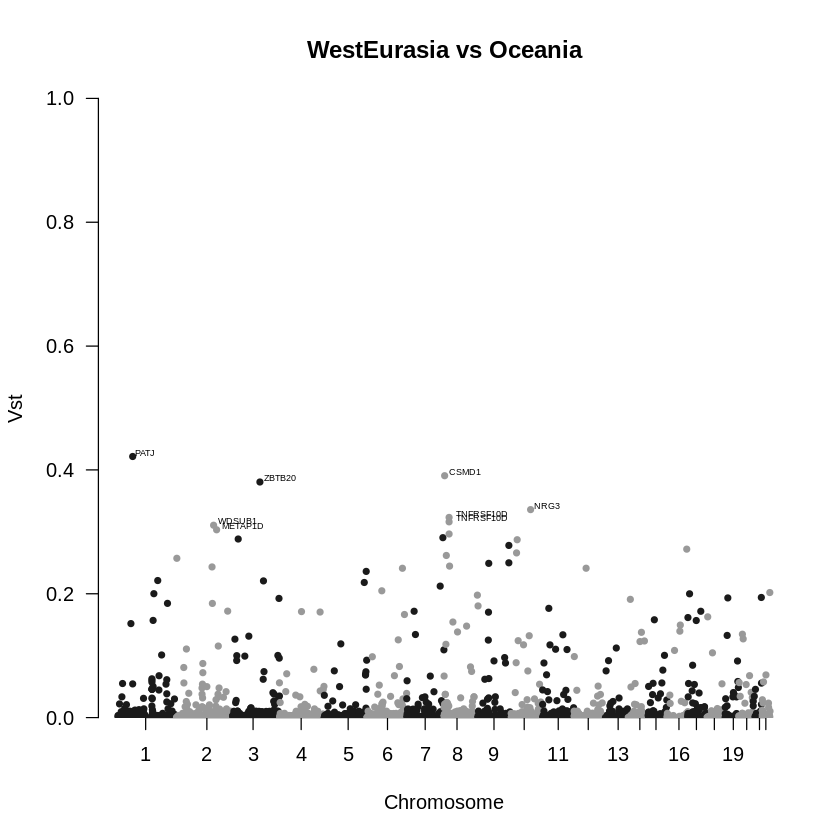

In [21]:
manhattan(df, logp = FALSE, annotatePval= 0.30,  annotateTop = FALSE, ylab="Vst", main='WestEurasia vs Oceania') #, chrlabs= c(1:22,"X")

<h1> Manhattan plot for each group

In [22]:
SNP <- df_merge$genes
CHR <- as.integer(df_merge$chr)
BP <- df_merge$start
#P <- df_merge$WestEurasia.Oceania

coordinates <- data.frame(SNP,CHR,BP)
coordinates$CHR[is.na(coordinates$CHR)] <- "X"
coordinates


Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


SNP,CHR,BP
<chr>,<chr>,<int>
MFSD14A,1,100517299
RBP7,1,10067509
RNF223,1,1009660
OLFM3,1,102395735
KIF1B,1,10272327
KIF1B,1,10282248
C1orf159,1,1051484
PEX14,1,10630864
NTNG1,1,107891259


In [23]:
n <- ncol(df_merge)
n

[1] 25

In [25]:
list_df <- lapply(names(df_merge)[-c(n-21, n)], function(x) 
               cbind(df_merge[x], df_merge[c(n-21, n)]))

In [ ]:
list_df

[1]  4 25